# Libraries

In [1]:
from operator import itemgetter

import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray
import fiona

import matplotlib
import matplotlib.pyplot as plt

from rasterio.enums import Resampling
import xarray

# Directories

In [2]:
wtd_csv_path = "/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv"
meteo_nc_paht = "/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc"
wtd_shp = "/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp"
piedmont_shp = "/leonardo_work/IscrC_DL4EO/trials/data/shapefile/piemonte_admin_boundaries.shp"
dtm_nc = "/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc"

# Data Loading 

In [3]:
wtd_data = pd.read_csv(wtd_csv_path, 
            dtype= {"sensor_id": "str"})

wtd_data = wtd_data.astype({"date":'datetime64[ns]'})

# per anagrafica stazioni: 
wtd_names  = gpd.read_file(wtd_shp, engine='fiona')
wtd_names = wtd_names.to_crs('epsg:4326')

dtm_roi = rioxarray.open_rasterio(dtm_nc, engine='fiona')
dtm_roi = dtm_roi.rio.write_crs("epsg:4326")


In [4]:
piedmont_bounds = gpd.read_file(piedmont_shp, engine='fiona')
piedmont_bounds = piedmont_bounds.to_crs('epsg:4326')
# remove the small enclaved Cuneo area inside Torino province
piedmont_bounds = piedmont_bounds[:-1]

# extract bound, useful for plots
piemonte_long_min, piemonte_lat_min, piemonte_long_max, piemonte_lat_max = piedmont_bounds.total_bounds

# extract Province names and coord, useful for plots
provinces_names = [piedmont_bounds["nome"][i] for i in range(0,len(piedmont_bounds))]
provinces_long = [piedmont_bounds["geometry"][i].representative_point().coords[0][0] for i in range(0,len(piedmont_bounds))]
provinces_lat = [piedmont_bounds["geometry"][i].representative_point().coords[0][1] for i in range(0,len(piedmont_bounds))]

In [5]:
wtd_data

,date,sensor_id,wtd
0,1996-01-01,00405910001,1.700000
1,1996-01-01,00408910001,NaN
2,1996-01-01,00407810001,NaN
3,1996-01-01,00105910001,NaN
4,1996-01-01,00112710001,NaN
...,...,...,...
317032,2023-12-31,00105110001,3.553333
317033,2023-12-31,00404110001,NaN
317034,2023-12-31,00121510001,14.500000
317035,2023-12-31,00104810001,2.056667


In [6]:
wtd_names
wtd_names[wtd_names["CODICE_PUN"] == "00107010001"]

,CODICE_PUN,CODICE_CI,NOME_PUNTO,COMUNE,LOCALITA,DATA_ATTIV,DATA_ESTIN,FALDA,geometry
0,00107010001,GWB-S5b,P15 Cavour,Cavour,lato cimitero,2009-01-01,None,Superficiale,POINT (7.38103 44.78737)


# Rasterize

In [7]:
wtd_data.dtypes

date         datetime64[ns]
sensor_id            object
wtd                 float64
dtype: object

In [8]:
wtd_data

,date,sensor_id,wtd
0,1996-01-01,00405910001,1.700000
1,1996-01-01,00408910001,NaN
2,1996-01-01,00407810001,NaN
3,1996-01-01,00105910001,NaN
4,1996-01-01,00112710001,NaN
...,...,...,...
317032,2023-12-31,00105110001,3.553333
317033,2023-12-31,00404110001,NaN
317034,2023-12-31,00121510001,14.500000
317035,2023-12-31,00104810001,2.056667


In [9]:
all_dates = wtd_data["date"].unique()
len(all_dates)

10227

In [10]:
sensor_id_list = wtd_data["sensor_id"].unique()
len(sensor_id_list)

31

In [11]:
sensor_coord_x_list = []
sensor_coord_y_list = []
for sensor in sensor_id_list:
    coord_x = wtd_names.loc[wtd_names["CODICE_PUN"] == sensor].geometry.x.values[0]
    coord_y = wtd_names.loc[wtd_names["CODICE_PUN"] == sensor].geometry.y.values[0]
    sensor_coord_x_list.append(coord_x)
    sensor_coord_y_list.append(coord_y)

In [12]:
from_id_to_coord_x_dict = {sensor_id_list[i]: sensor_coord_x_list[i] for i in range(len(sensor_coord_x_list))}
from_id_to_coord_y_dict = {sensor_id_list[i]: sensor_coord_y_list[i] for i in range(len(sensor_coord_y_list))}

In [13]:
queries = list(wtd_data["sensor_id"].values)
coordinates_x = itemgetter(*queries)(from_id_to_coord_x_dict)
coordinates_y = itemgetter(*queries)(from_id_to_coord_y_dict)

In [14]:
wtd_data["x"] = coordinates_x
wtd_data["y"] = coordinates_y

In [15]:
wtd_data

,date,sensor_id,wtd,x,y
0,1996-01-01,00405910001,1.700000,7.640289,44.698854
1,1996-01-01,00408910001,NaN,7.726400,44.567817
2,1996-01-01,00407810001,NaN,7.537215,44.418627
3,1996-01-01,00105910001,NaN,7.723791,44.860859
4,1996-01-01,00112710001,NaN,7.673142,44.963005
...,...,...,...,...,...
317032,2023-12-31,00105110001,3.553333,7.598704,44.956561
317033,2023-12-31,00404110001,NaN,7.735140,44.787024
317034,2023-12-31,00121510001,14.500000,7.894828,45.005577
317035,2023-12-31,00104810001,2.056667,7.770635,44.965446


In [16]:
wtd_data.dtypes

date         datetime64[ns]
sensor_id            object
wtd                 float64
x                   float64
y                   float64
dtype: object

In [17]:
upscale_factor = 0.1
new_width = int(dtm_roi.rio.width * upscale_factor)
new_height = int(dtm_roi.rio.height * upscale_factor)

dtm_roi_upsampled = dtm_roi.rio.reproject(
    dtm_roi.rio.crs,
    shape=(new_height, new_width),
    resampling=Resampling.bilinear,
)

In [18]:
dtm_roi_upsampled

<xarray.DataArray '__xarray_dataarray_variable__' (band: 1, y: 114, x: 168)> Size: 77kB
array([[[2899.5454 , 2800.0447 , 2652.8933 , ...,  207.18225,
          203.91689,  200.8909 ],
        [2745.5928 , 2573.3943 , 2378.1335 , ...,  201.14403,
          197.62209,  194.39249],
        [2582.547  , 2200.7563 , 2236.475  , ...,  196.59752,
          194.13895,  190.74823],
        ...,
        [1816.2076 , 2051.5916 , 2158.6135 , ...,  829.5154 ,
          808.9886 ,  741.43695],
        [1769.3004 , 1817.0792 , 1762.4233 , ...,  840.6071 ,
          823.92474,  812.00555],
        [1609.5911 , 1636.23   , 1672.0851 , ...,  833.7745 ,
          827.46497,  753.8922 ]]], dtype=float32)
Coordinates:
  * x            (x) float64 1kB 6.63 6.639 6.647 6.655 ... 8.009 8.017 8.025
  * y            (y) float64 912B 45.26 45.25 45.24 45.24 ... 44.33 44.32 44.31
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    NETCDF_DIM_EXTRA:  {band}
    AREA_OR_POINT:     Area
    scale_factor:      1.0
    add_offset:        0.0
    NETCDF_DIM_band:   1
    _FillValue:        nan

In [19]:
wtd_data_geop = gpd.GeoDataFrame(
    wtd_data, geometry=gpd.points_from_xy(wtd_data["x"], 
                                          wtd_data["y"]), crs="EPSG:4326")

In [20]:
wtd_data_geop = wtd_data_geop[["date","wtd","geometry"]]
wtd_data_geop

,date,wtd,geometry
0,1996-01-01,1.700000,POINT (7.64029 44.69885)
1,1996-01-01,NaN,POINT (7.7264 44.56782)
2,1996-01-01,NaN,POINT (7.53722 44.41863)
3,1996-01-01,NaN,POINT (7.72379 44.86086)
4,1996-01-01,NaN,POINT (7.67314 44.963)
...,...,...,...
317032,2023-12-31,3.553333,POINT (7.5987 44.95656)
317033,2023-12-31,NaN,POINT (7.73514 44.78702)
317034,2023-12-31,14.500000,POINT (7.89483 45.00558)
317035,2023-12-31,2.056667,POINT (7.77064 44.96545)


In [ ]:
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial
from tqdm import tqdm

In [36]:
# Rasterize and create nc file

rasterized_ds_list = []
for date_idx in range(len(all_dates)):
    
    vector_ds = wtd_data_geop.loc[wtd_data_geop["date"] == all_dates[date_idx],:]

    rasterized_ds = make_geocube(vector_data=vector_ds,
                                 measurements=['wtd'],
                                 output_crs="epsg:4326",
                                 resolution=(dtm_roi_upsampled.rio.transform().a, dtm_roi_upsampled.rio.transform().e))
    
    rasterized_ds_list.append(rasterized_ds)

    # if date_idx == 100:
    #     break

In [37]:
wtd_data_raserized = xarray.concat(rasterized_ds_list, dim = "time")
wtd_data_raserized = wtd_data_raserized.assign_coords({"time": all_dates})

In [38]:
wtd_data_raserized

<xarray.Dataset> Size: 476MB
Dimensions:      (time: 10227, y: 82, x: 71)
Coordinates:
  * y            (y) float64 656B 44.42 44.43 44.43 44.44 ... 45.08 45.09 45.09
  * x            (x) float64 568B 7.896 7.887 7.879 7.87 ... 7.326 7.317 7.309
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 82kB 1996-01-01 1996-01-02 ... 2023-12-31
Data variables:
    wtd          (time, y, x) float64 476MB nan nan nan nan ... nan nan nan nan

In [ ]:
wtd_data_raserized.to_netcdf("wtd_rasterized_1996_2023.nc")

In [47]:
prova = xarray.open_dataset("sample_all.nc")

In [43]:
len(wtd_data_geop.loc[wtd_data_geop["date"] == np.datetime64("2016-04-10")].dropna())

20

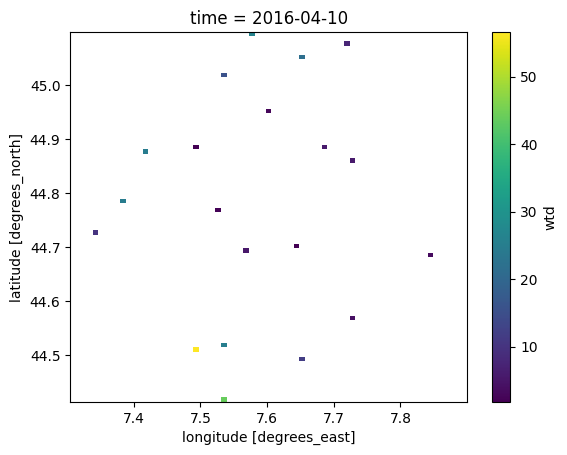

In [48]:
prova["wtd"].sel(time = np.datetime64("2016-04-10")).plot()

In [19]:
sample_date = "2020-08-22"
sample_geopd = wtd_data_geop.loc[wtd_data_geop["date"] == np.datetime64(sample_date),:]
sample_geopd

,date,wtd,geometry
279000,2020-08-22,NaN,POINT (7.64029 44.69885)
279001,2020-08-22,NaN,POINT (7.7264 44.56782)
279002,2020-08-22,38.936667,POINT (7.53722 44.41863)
279003,2020-08-22,6.170000,POINT (7.72379 44.86086)
279004,2020-08-22,3.933333,POINT (7.67314 44.963)
279005,2020-08-22,2.390000,POINT (7.4948 44.88944)
279006,2020-08-22,4.680000,POINT (7.68794 44.77265)
279007,2020-08-22,23.590000,POINT (7.53227 44.51818)
279008,2020-08-22,21.900000,POINT (7.65555 45.051)
279009,2020-08-22,24.223333,POINT (7.3085 44.82984)


In [22]:
sample_wtd_grid = make_geocube(
    vector_data=sample_geopd,
    measurements=['wtd'],
    output_crs="epsg:4326",
    resolution=(dtm_roi_upsampled.rio.transform().a, dtm_roi_upsampled.rio.transform().e),
)

In [23]:
sample_wtd_grid

<xarray.Dataset> Size: 48kB
Dimensions:      (y: 82, x: 71)
Coordinates:
  * y            (y) float64 656B 44.42 44.43 44.43 44.44 ... 45.08 45.09 45.09
  * x            (x) float64 568B 7.896 7.887 7.879 7.87 ... 7.326 7.317 7.309
    spatial_ref  int64 8B 0
Data variables:
    wtd          (y, x) float64 47kB nan nan nan nan nan ... nan nan nan nan nan

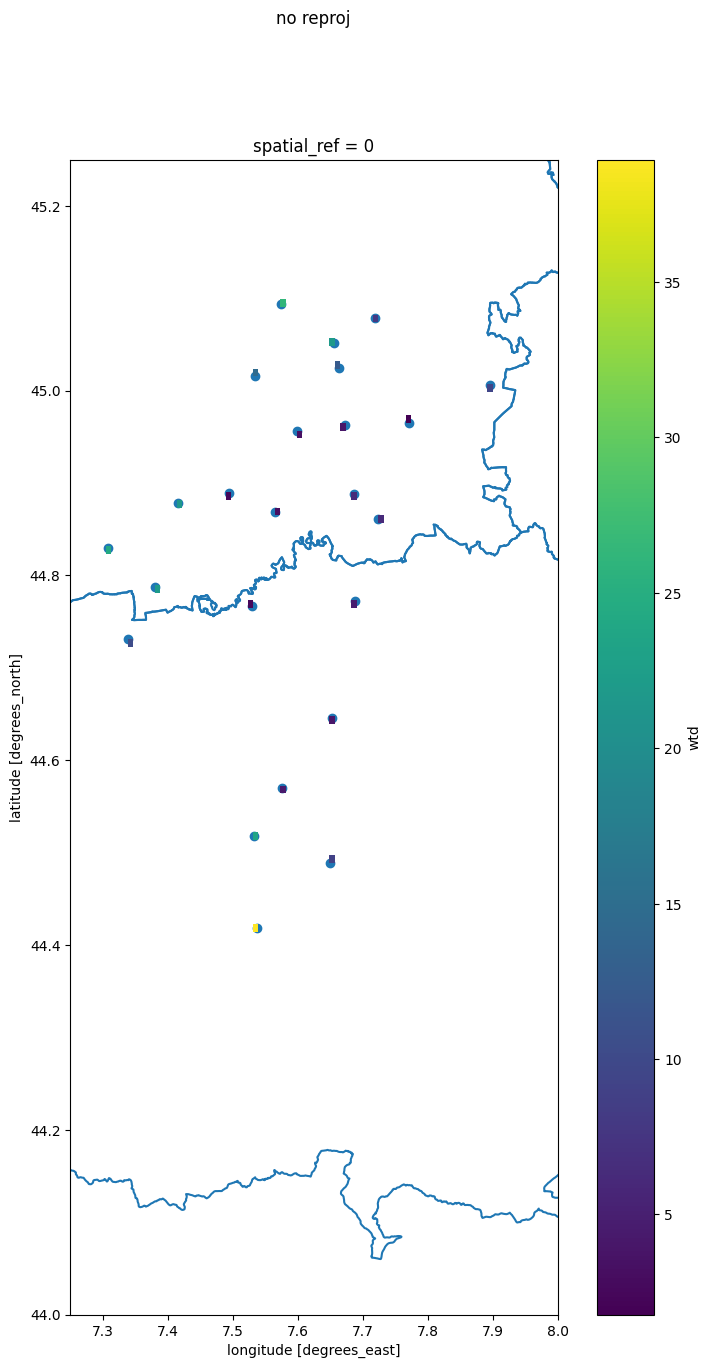

In [24]:
fig, ax = plt.subplots(figsize = (10,15))
sample_geopd.dropna().plot(ax = ax)
sample_wtd_grid["wtd"].plot(ax = ax)
piedmont_bounds.boundary.plot(ax = ax)
ax.set_xlim((7.25, 8))
ax.set_ylim((44, 45.25))
fig.suptitle("no reproj")
plt.show()